In [1]:
%%time

!pip install gensim

CPU times: user 17.9 ms, sys: 11.7 ms, total: 29.6 ms
Wall time: 2.7 s


In [3]:
%%time

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
misconception = pd.read_csv('./data/misconception_mapping.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

CPU times: user 15 ms, sys: 3.68 ms, total: 18.7 ms
Wall time: 21.1 ms


In [4]:
%%time

# Defining the columns to keep for each dataset
train_columns = ['QuestionId', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
test_columns = ['QuestionId', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']

# Dropping other columns from train and test datasets
train_filtered = train[train_columns]
test_filtered = test[test_columns]

train_filtered
test_filtered

CPU times: user 1.64 ms, sys: 648 µs, total: 2.29 ms
Wall time: 2.52 ms


,QuestionId,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct


# Check Missing Values

In [5]:
%%time

# Checking for missing values in the combined dataset
missing_values = train_filtered.isnull().sum()

missing_values

CPU times: user 1.87 ms, sys: 728 µs, total: 2.6 ms
Wall time: 2.25 ms


QuestionId      0
QuestionText    0
AnswerAText     0
AnswerBText     0
AnswerCText     0
AnswerDText     0
dtype: int64

# Clean Text Except Formula / Format Mathematics

In [6]:
%%time

import re

# Function to clean text but keep mathematical symbols and formatting
def clean_text(text):
    # Remove unnecessary symbols but retain mathematical expressions
    cleaned_text = re.sub(r'[^A-Za-z0-9\s\(\)\[\]\+\-\*/\\]', '', text)
    return cleaned_text

# Apply this function to the Answer and Question text columns
train_filtered['QuestionText_Clean'] = train_filtered['QuestionText'].apply(lambda x: clean_text(x))
train_filtered['AnswerAText_Clean'] = train_filtered['AnswerAText'].apply(lambda x: clean_text(x))
train_filtered['AnswerBText_Clean'] = train_filtered['AnswerBText'].apply(lambda x: clean_text(x))
train_filtered['AnswerCText_Clean'] = train_filtered['AnswerCText'].apply(lambda x: clean_text(x))
train_filtered['AnswerDText_Clean'] = train_filtered['AnswerDText'].apply(lambda x: clean_text(x))

train_filtered[['QuestionText', 'QuestionText_Clean', 'AnswerAText_Clean', 'AnswerBText_Clean', 'AnswerCText_Clean', 'AnswerDText_Clean']].head()

CPU times: user 15.9 ms, sys: 1.07 ms, total: 16.9 ms
Wall time: 16.4 ms


,QuestionText,QuestionText_Clean,AnswerAText_Clean,AnswerBText_Clean,AnswerCText_Clean,AnswerDText_Clean
0,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,"Simplify the following, if possible: \( \frac{...",Simplify the following if possible \( \fracm2+...,\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,Tom and Katie are discussing the \( 5 \) plant...,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct
3,The angles highlighted on this rectangle with ...,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90\circ \),Not enough information
4,The equation \( f=3 r^{2}+3 \) is used to find...,The equation \( f3 r2+3 \) is used to find val...,\( 30 \),\( 27 \),\( 51 \),\( 24 \)


# Preprocessing Text

In [7]:
%%time

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string

# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

CPU times: user 378 ms, sys: 101 ms, total: 480 ms
Wall time: 16.4 s


In [8]:
%%time

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /Users/data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.
CPU times: user 60.7 ms, sys: 17.8 ms, total: 78.5 ms
Wall time: 496 ms


In [9]:
%%time

# Define stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

CPU times: user 707 µs, sys: 1.01 ms, total: 1.72 ms
Wall time: 1.18 ms


In [10]:
%%time

# Combined function to clean and preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove punctuation and stop words, and lemmatize the words
    cleaned_words = [
        lemmatizer.lemmatize(word) 
        for word in words 
        if word not in stop_words and word not in punctuation
    ]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

# Applying this function to a column in the dataframe
train_filtered['cleaned_QuestionText'] = train_filtered['QuestionText'].apply(preprocess_text)
train_filtered['cleaned_AnswerAText'] = train_filtered['AnswerAText'].apply(preprocess_text)
train_filtered['cleaned_AnswerBText'] = train_filtered['AnswerBText'].apply(preprocess_text)
train_filtered['cleaned_AnswerCText'] = train_filtered['AnswerCText'].apply(preprocess_text)
train_filtered['cleaned_AnswerDText'] = train_filtered['AnswerDText'].apply(preprocess_text)

train_filtered[['QuestionText', 'cleaned_QuestionText', 'cleaned_AnswerAText', 'cleaned_AnswerBText', 'cleaned_AnswerCText', 'cleaned_AnswerDText']].head()

CPU times: user 1.44 s, sys: 44.7 ms, total: 1.49 s
Wall time: 1.49 s


,QuestionText,cleaned_QuestionText,cleaned_AnswerAText,cleaned_AnswerBText,cleaned_AnswerCText,cleaned_AnswerDText
0,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,3 \times 2+4-5 bracket need go make answer equ...,3 \times 2+4 -5,3 \times 2+ 4-5,3 \times 2+4-5,need bracket
1,"Simplify the following, if possible: \( \frac{...",simplify following possible \frac m^ 2 +2 m-3 m-3,m+1,m+2,m-1,simplify
2,Tom and Katie are discussing the \( 5 \) plant...,tom katie discussing 5 plant height 24 \mathrm...,tom,katie,tom katie,neither correct
3,The angles highlighted on this rectangle with ...,angle highlighted rectangle different length s...,acute,obtuse,90^ \circ,enough information
4,The equation \( f=3 r^{2}+3 \) is used to find...,equation f=3 r^ 2 +3 used find value table val...,30,27,51,24


# Encode Categorical Columns

In [11]:
%%time

# Using label encoding for the categorical columns 
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Identify categorical columns in train and test datasets
categorical_columns_train = train_filtered.select_dtypes(include=['object']).columns
categorical_columns_test = test_filtered.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding for categorical columns in train and test datasets
train_encoded = pd.get_dummies(train_filtered, columns=categorical_columns_train, drop_first=True)
test_encoded = pd.get_dummies(test_filtered, columns=categorical_columns_test, drop_first=True)

# Align columns by adding missing columns to the test or train dataset
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

train_encoded.head(), test_encoded.head()

CPU times: user 163 ms, sys: 27.6 ms, total: 190 ms
Wall time: 191 ms


(   QuestionId  \
 0           0   
 1           1   
 2           2   
 3           3   
 4           4   
 
    QuestionText_![A bar chart with blue bars. The x-axis is labelled with fruits and the y-axis is titled "Number of Children" and its scale is from 0 to 60 in steps of 10. The bars represent the following numbers of children: Banana, 20; Apple, 40; Kiwi Fruits, 50; Orange, 30; Pineapple, 25.]() Which of the following statements is true?  \
 0                                                  0                                                                                                                                                                                                                                                                                                  
 1                                                  0                                                                                                                                                     

# Visualize WordCloud

In [13]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 1.2 MB/s eta 0:00:00a 0:00:01


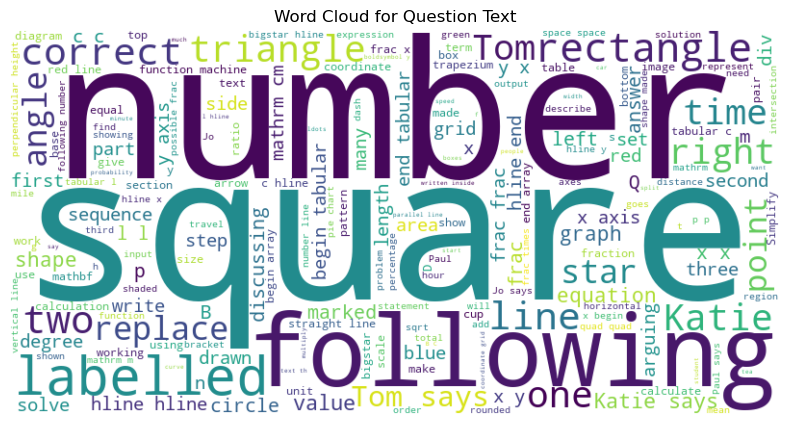

CPU times: user 844 ms, sys: 105 ms, total: 949 ms
Wall time: 2.99 s


In [14]:
%%time

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Create the corpus using the original 'QuestionText' column after basic cleaning
corpus = ' '.join(train_filtered['QuestionText'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question Text')
plt.show()

# Count Vocab

In [15]:
%%time

# Count the vocabulary (unique words) in the corpus

words = corpus.split()
vocabulary_count = len(set(words))

vocabulary_count

CPU times: user 3.5 ms, sys: 46 µs, total: 3.54 ms
Wall time: 3.55 ms


6192

# Visualize Most Common Words

<Figure size 1000x600 with 0 Axes>

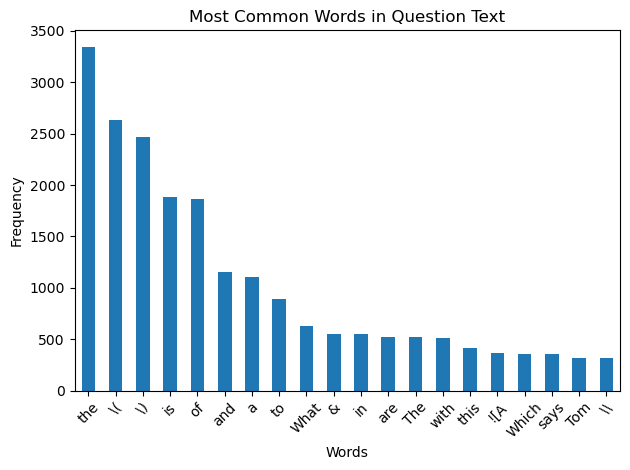

CPU times: user 102 ms, sys: 4.77 ms, total: 107 ms
Wall time: 108 ms


In [16]:
%%time

from collections import Counter
import pandas as pd

# Split the corpus into individual words
words = corpus.split()

# Count the frequency of each word
word_counts = Counter(words)

# Create a DataFrame with the most common words
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(10, 6))
common_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False)
plt.title('Most Common Words in Question Text')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Perform LDA Topic Modelling

In [17]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare the text data for LDA by vectorizing the corpus
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(train_filtered['QuestionText'].astype(str))

# Perform LDA to find 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Get the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics.append(f"Topic {topic_idx+1}: {' '.join(top_features)}")

topics

CPU times: user 1.4 s, sys: 7.25 ms, total: 1.41 s
Wall time: 1.93 s


['Topic 1: hline tabular star end begin replace bigstar array quad equation',
 'Topic 2: point line following mathrm triangle axis angle coordinates degrees shows',
 'Topic 3: says frac tom katie correct times following discussing function answer',
 'Topic 4: labelled graph number axis cm mathrm area time triangle height',
 'Topic 5: line shape squares left rectangle right lines square number diagram']

# Create BoW & TF-IDF

In [18]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 'QuestionText' as the text column to convert corpus
corpus = train_filtered['QuestionText'].astype(str).tolist()

# Bag of Words (BoW) conversion
vectorizer_bow = CountVectorizer(max_features=1000)  # You can limit the number of features if needed
X_bow = vectorizer_bow.fit_transform(corpus)

# TF-IDF conversion
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(corpus)

# Display the shape of the resulting matrices
X_bow.shape, X_tfidf.shape

CPU times: user 45.7 ms, sys: 1.72 ms, total: 47.5 ms
Wall time: 48.6 ms


((1869, 1000), (1869, 1000))

# Create Tokenized & Vectors

In [19]:
%%time

from gensim.models import Word2Vec

# Tokenize the text 
tokenized_corpus = [question.split() for question in corpus]

# Train a Word2Vec model on the tokenized text
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Get the vector for a word
word_vector = word2vec_model.wv['What']

word_vector

CPU times: user 402 ms, sys: 26.9 ms, total: 429 ms
Wall time: 315 ms


array([-0.38891706,  0.969543  , -0.0420005 ,  0.12658371, -0.13501818,
       -0.85210603,  0.6888969 ,  1.4037576 , -1.0297313 , -0.38892794,
       -0.31012607, -0.8352975 , -0.0837552 ,  0.32928783,  0.19040567,
       -0.420834  ,  0.52235055, -0.40921405, -0.34893876, -1.9781138 ,
        0.43823287,  0.48646715,  1.0598078 , -0.2717784 ,  0.33383045,
       -0.48567963, -0.22079872, -0.41847834, -0.71544325,  0.30541182,
        0.6450228 , -0.14084643,  0.46304607, -1.1514102 , -0.3228972 ,
        0.7817919 ,  0.1678744 , -0.39755908, -0.12245192, -1.1605269 ,
       -0.3484456 , -0.37333885, -0.22041734,  0.5489045 ,  0.65244514,
        0.03564307, -0.62797433, -0.25088078,  0.17107587,  0.58914465,
        0.13739711, -0.49446744, -0.51450264, -0.47499615,  0.03893412,
       -0.00342297,  0.96623886, -0.17830105, -0.7297579 ,  0.48963764,
       -0.00598167, -0.13833335, -0.02419441, -0.02381531, -0.6700651 ,
        0.5129228 ,  0.30380464,  0.7959517 , -0.85577047,  1.00

In [20]:
%%time

terms = ['triangle', 'rectangle', 'function', 'equation', 'graph']

# Get word vectors for each term in the list
word_vectors = {term: word2vec_model.wv[term] for term in terms if term in word2vec_model.wv}

word_vectors

CPU times: user 28 µs, sys: 2 µs, total: 30 µs
Wall time: 29.8 µs


{'triangle': array([-0.35456958,  0.7309467 ,  0.28305104, -0.11263315,  0.0720311 ,
        -0.89594716,  0.34468842,  1.1113275 , -0.65480494, -0.42668384,
        -0.16662787, -0.6065144 , -0.2711416 ,  0.274364  ,  0.27675787,
        -0.42154887,  0.21854964, -0.25381187, -0.22012363, -1.3975221 ,
         0.0632327 ,  0.15484077,  0.5954362 , -0.12420099,  0.02710578,
        -0.25127742, -0.23899792, -0.40465942, -0.494246  ,  0.06852955,
         0.2893663 , -0.03221507,  0.22330965, -0.8152368 , -0.06366741,
         0.5072218 ,  0.22528961, -0.33607164, -0.17152224, -0.79221994,
        -0.15188071, -0.5143464 , -0.29198903,  0.4142397 ,  0.3505026 ,
        -0.17547859, -0.44833657, -0.05421739,  0.20354602,  0.30209067,
         0.12212488, -0.28004372, -0.14963418, -0.18635903, -0.1254717 ,
         0.10971648,  0.669922  , -0.17080498, -0.5404787 ,  0.47302675,
         0.08754923,  0.09622996, -0.03422805,  0.02105081, -0.38868088,
         0.47168943,  0.37027064,  0.65

In [21]:
%%time

# Convert the entire text into vectors (average word vectors for each document)
document_vectors = []
for tokens in tokenized_corpus:
    vector = sum([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]) / len(tokens)
    document_vectors.append(vector)

CPU times: user 78.6 ms, sys: 1.74 ms, total: 80.3 ms
Wall time: 79.2 ms


# K-Means Clustering

In [22]:
%%time

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize the data using StandardScaler, setting with_mean=False for sparse data
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Apply K-Means with an arbitrary number of clusters (e.g., 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
train_filtered['Cluster'] = kmeans.fit_predict(X_scaled)

train_filtered[['AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'Cluster']].head()

CPU times: user 630 ms, sys: 219 ms, total: 850 ms
Wall time: 5.82 s


,AnswerAText,AnswerBText,AnswerCText,AnswerDText,Cluster
0,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,1
1,\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,1
2,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1
3,acute,obtuse,\( 90^{\circ} \),Not enough information,1
4,\( 30 \),\( 27 \),\( 51 \),\( 24 \),1


# Visualize K-Means Clustering For Answer

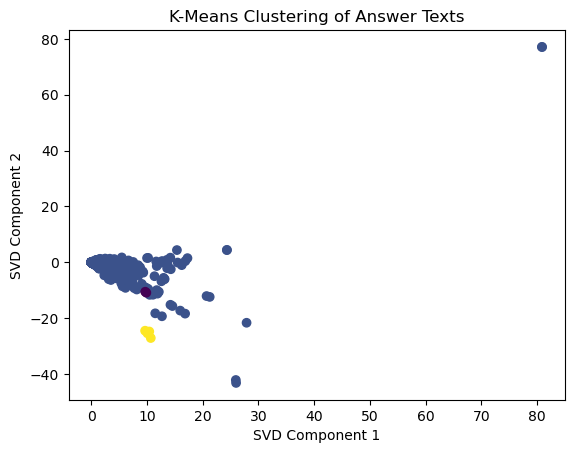

CPU times: user 536 ms, sys: 259 ms, total: 796 ms
Wall time: 113 ms


In [23]:
%%time

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reduce the dimensionality of the data to 2D for visualization using TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_scaled)

# Plot the clusters
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=train_filtered['Cluster'], cmap='viridis', marker='o')
plt.title('K-Means Clustering of Answer Texts')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()

# The most similar questions

In [24]:
%%time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create a TF-IDF vectorizer to convert 'QuestionText' into numerical vectors
vectorizer = TfidfVectorizer()

# Fit and transform the 'QuestionText' column to get the TF-IDF matrix
question_vectors = vectorizer.fit_transform(train_filtered['QuestionText'].values)

# Find the vector for the first question (query vector)
query_vector = question_vectors[0]

# Compute cosine similarities between the query and all other questions
cosine_similarities = cosine_similarity(query_vector, question_vectors)

# Get the indices of the most similar questions
most_similar_indices = cosine_similarities[0].argsort()[::-1][1:6]  # Top 5 most similar

# The most similar questions 
most_similar_questions = train_filtered.iloc[most_similar_indices][['QuestionText']]
most_similar_questions

CPU times: user 142 ms, sys: 63.3 ms, total: 206 ms
Wall time: 25.7 ms


,QuestionText
1311,\[\n12 \times 6-1+2\n\]\nWhere do the brackets...
1530,What is the answer to \( 4 c \times 5 d \) ?
728,Add brackets to this calculation to make the a...
1488,To calculate \( 53^{2} \) you need to do...
1542,To calculate \( 47^{2} \) you need to do...


# The most similar answers

In [25]:
%%time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create a TF-IDF vectorizer to convert text into numerical vectors
vectorizer = TfidfVectorizer()

# Fit and transform the 'AnswerAText' column to get the TF-IDF matrix
answer_vectors = vectorizer.fit_transform(train_filtered['AnswerAText'].values)

# Find the vector for the first answer (query vector)
query_vector = answer_vectors[0]

# Compute cosine similarities between the query and all other answers
cosine_similarities = cosine_similarity(query_vector, answer_vectors)

# Get the indices of the most similar answers
most_similar_indices = cosine_similarities[0].argsort()[::-1][1:6]  # Top 5 most similar

# The most similar answers
most_similar_answers = train_filtered.iloc[most_similar_indices][['AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']]
most_similar_answers

CPU times: user 44.2 ms, sys: 18.9 ms, total: 63.2 ms
Wall time: 7.93 ms


,AnswerAText,AnswerBText,AnswerCText,AnswerDText
36,\( 4 \times d \),\( d 4 \),\( 4 d \),\( d^{4} \)
1363,\( \times 3 \),\( \times 6 \),\( \times 9 \),\( \times 27 \)
441,\( (2 \times 7)+(4 \times 2)+(4 \times 7) \),\( [(2 \times 7)+(4 \times 2)+(4 \times 7)] \t...,\( (2 \times 7) \times(4 \times 2) \times(4 \t...,\( 2 \times 4 \times 7 \)
435,\( 2 \times(-2)-(-4) \times 4 \),\( -28-(-4) \times 2 \),\( (-5)^{2}+5 \),\( (-42) \div(-2)+1 \)
359,\( m \times m \times m \),\( m^{3} \),\( 3 m \),\( \mathrm{mmm} \)
